In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import sys
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from skimage.metrics import peak_signal_noise_ratio

import torch
import torch.optim
import torch.nn as nn
import torchvision

import PIL
from PIL import Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
sigma = 25
sigma_ = sigma/255.

In [ ]:
# common_utils.py

def crop_image(img, d=32):
    '''Make dimensions divisible by `d`'''

    new_size = (img.size[0] - img.size[0] % d,
                img.size[1] - img.size[1] % d)

    bbox = [
            int((img.size[0] - new_size[0])/2),
            int((img.size[1] - new_size[1])/2),
            int((img.size[0] + new_size[0])/2),
            int((img.size[1] + new_size[1])/2),
    ]

    img_cropped = img.crop(bbox)
    return img_cropped

def get_params(opt_over, net, net_input):
    '''Returns parameters that we want to optimize over.

    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []

    for opt in opt_over_list:

        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'

    return params

def get_image_grid(images_np, nrow=8):
    '''Creates a grid from a list of images by concatenating them.'''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)

    return torch_grid.numpy()

def plot_image_grid(images_np, nrow=8, factor=1, interpolation='lanczos', titles=None):
    """Draws images in a grid with optional titles above each image.

    Args:
        images_np: list of images, each image is np.array of size 3xHxW or 1xHxW
        nrow: how many images will be in one row
        factor: size of the plt.figure
        interpolation: interpolation used in plt.imshow
        titles: list of titles for each image (optional)
    """
    n_channels = max(x.shape[0] for x in images_np)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"

    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)

    plt.figure(figsize=(len(images_np) + factor, 12 + factor))

    for i, img in enumerate(images_np):
        plt.subplot(len(images_np) // nrow + 1, nrow, i + 1)
        if img.shape[0] == 1:
            plt.imshow(img[0], cmap='gray', interpolation=interpolation)
        else:
            plt.imshow(img.transpose(1, 2, 0), interpolation=interpolation)
        if titles and i < len(titles):
            plt.title(titles[i], fontsize=8)
        plt.axis('off')

    plt.show()

    return grid

def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img

def get_image(path, imsize=-1):
    """Load an image and resize to a specific size.

    Args:
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np



def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_()
    else:
        assert False

def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`)
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler.
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)

        fill_noise(net_input, noise_type)
        net_input *= var
    elif method == 'meshgrid':
        assert input_depth == 2
        X, Y = np.meshgrid(np.arange(0, spatial_size[1])/float(spatial_size[1]-1), np.arange(0, spatial_size[0])/float(spatial_size[0]-1))
        meshgrid = np.concatenate([X[None,:], Y[None,:]])
        net_input=  np_to_torch(meshgrid)
    else:
        assert False

    return net_input

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.

    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def np_to_pil(img_np):
    '''Converts image in np.array format to PIL image.

    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)

    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.

    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.

    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations
    """
    if optimizer_type == 'LBFGS':
        # Do several steps with adam first
        optimizer = torch.optim.Adam(parameters, lr=0.001)
        for j in range(100):
            optimizer.zero_grad()
            closure()
            optimizer.step()

        print('Starting optimization with LBFGS')
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    elif optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)

        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
    else:
        assert False

In [ ]:
# common.py

def add_module(self, module):
    self.add_module(str(len(self) + 1), module)

torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs:
                diff2 = (inp.size(2) - target_shape2) // 2
                diff3 = (inp.size(3) - target_shape3) // 2
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)


class GenNoise(nn.Module):
    def __init__(self, dim2):
        super(GenNoise, self).__init__()
        self.dim2 = dim2

    def forward(self, input):
        a = list(input.size())
        a[1] = self.dim2
        # print (input.data.type())

        b = torch.zeros(a).type_as(input.data)
        b.normal_()

        x = torch.autograd.Variable(b)

        return x

def act(act_fun = 'LeakyReLU'):
    '''
        Either string defining an activation function or module (e.g. nn.ReLU)
    '''
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        else:
            assert False
    else:
        return act_fun()


def bn(num_features):
    return nn.BatchNorm2d(num_features)


def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero', downsample_mode='stride'):
    downsampler = None

    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0

    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)


    layers = filter(lambda x: x is not None, [padder, convolver, downsampler])
    return nn.Sequential(*layers)

In [ ]:
def get_noisy_image(img_np, sigma):
    """Adds Gaussian noise to an image.

    Args:
        img_np: image, np.array with values from 0 to 1
        sigma: std of the noise
    """
    img_noisy_np = np.clip(img_np + np.random.normal(scale=sigma, size=img_np.shape), 0, 1).astype(np.float32)
    img_noisy_pil = np_to_pil(img_noisy_np)

    return img_noisy_pil, img_noisy_np

In [ ]:
def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=3, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):
    if NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11,
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)
    else:
        assert False

    return net

# Skip Model

In [ ]:
# Skip network architecture
def skip(
        num_input_channels=2, num_output_channels=3,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.

    Arguments:
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down)

     # Ensuring that upsample and downsample modes are properly set for each scale
    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales

    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):
        # Create deeper layer and skip connection for each scale
        deeper = nn.Sequential()
        skip = nn.Sequential()

        # Skip connection if specified
        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper))
        else:
            model_tmp.add(deeper)

        # Batch normalization
        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        # Build skip connection
        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))

        # Build deeper layer (downsampling)
        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper_main = nn.Sequential()

        # Handling the deepest layer differently
        if i == len(num_channels_down) - 1:
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        # Add upsampling layer
        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        # Add upsampling path
        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))


        # Add 1x1 convolution if specified
        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    # Add final convolution layer
    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    # Add sigmoid activation if specified
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model

# Load Image

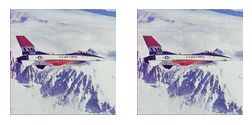

In [ ]:
fname = 'data/F16_GT.png'

# Add synthetic noise
img_pil = crop_image(get_image(fname, imsize)[0], d=32)
img_np = pil_to_np(img_pil)

img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

if PLOT:
    plot_image_grid([img_np, img_noisy_np], 2, 1);

# Setup

In [ ]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

num_iter = 3000
input_depth = 32
figsize = 4


net = get_net(input_depth, 'skip', pad,
              skip_n33d=128,
              skip_n33u=128,
              skip_n11=4,
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

Number of params: 2217831


# Main Loop

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

i = 0
def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()


    psrn_noisy = peak_signal_noise_ratio(img_noisy_np, out.detach().cpu().numpy()[0])
    psrn_gt    = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0])
    psrn_gt_sm = peak_signal_noise_ratio(img_np, out_avg.detach().cpu().numpy()[0])

    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1),
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)



    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
out_np = torch_to_np(net(net_input))
plot_image_grid([img_np, img_noisy_np, out_np], 3, 11, titles=['Original', 'Noisy', 'Denoised']);